In [89]:
import numpy as np
import sklearn as sk
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from sklearn.metrics import make_scorer
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles
import scipy.io as spio
from MixGauss import MixGauss
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from FALKON import FALKON
from GridsearchCV_FALKON import GridSearchCV_FALKON

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from two_moons import two_moons
from regularizedKernLSTrain import regularizedKernLSTrain as KRR_Train
from separatingFKernRLS import separatingFKernRLS
from kernel_kmeans import KernelKMeans
import time
def tic():
    global st_tictoc
    st_tictoc = time.time()
def toc():
    import time
    if 'st_tictoc' in globals():
        et_tictoc = time.time() - st_tictoc
        return et_tictoc
    else:
        print(f'ERROR: Start time not set')
        
np.random.seed(9)

# KERNELS 

# Study the Kernel matrix


The function MixGauss(means, sigmas, n) generates dataset X,Y where the X is composed of mixed classes, each class being generated according to a Gaussian distribution with given mean and standard deviation. The points in the dataset X are enumerated from 0 to n-1, and Y represents the label of each point.

We start generating two classes of points leaving in a 2D space. The first class is centered in (-0.5,-0.5) with standard deviation 0.5 and the second one in (0.5,0.5) with standard deviation 0.3. Each class is made of 15 points.

In [90]:
X, Y = MixGauss(means=[[-.5,-.5],[.5,.5]], sigmas=[0.5, 0.3], n=15)

Given the generated points $X = \{\hat x_1,\dots,\hat x_n\}, Y=\{\hat y_1,\dots,\hat y_n\}$, for a fixed Gaussian (RBF) kernel 

$$
k(a,b) = exp \Bigg\{-\frac{\|a - b\|^2}{2\sigma^2}\Bigg\},
$$

where $\sigma$ is the badwidth of the kernel.

Build the kernel matrix $K$, where the component $i,j$ of the matrix is defined by  $(K)_{i,j} = k(\hat x_i,\hat x_j)$.

In [92]:
def plt_hm(sigma):
### BUILD THE KERNEL MATRIX K. USE THE scikit-learn FUNCTION rbf_kernel 
### NOTE: how are sigma and gamma related in scikit-learn? (CAREFUL gamma != sigma)
    K = ...
###--------------------------------------------------------------------
    ax = sns.heatmap(K, linewidth=.5, vmin=0, vmax=1)
    plt.show()

interactive_plot = interactive(plt_hm, {'manual': True}, sigma=(.1, 5.0))
output = interactive_plot.children[-1]

interactive_plot

interactive(children=(FloatSlider(value=2.5500000000000003, description='sigma', max=5.0, min=0.1), Button(des…

How does the kernel matrix changes for the bandwidth of the kernel $\sigma$?
Remember that the kernel function is a measure of similarity (distance_max - distance) between two points.
Can we tell the points comes from two distinct classes? Why\?

# The shape of the learned function

We now generate $n$ = 6 points $X \subseteq \mathbb{R}$ in a 1D space with $Y \subseteq \mathbb{R}$.

In [93]:
X = np.array([-2 , -.5 , 1.5, 2.7, 4, 4.4]).reshape(-1,1)
Y = np.array([-1, 1, 1.3, -.5, 3, -.9]).reshape(-1,1)

Given the generated training points $X = \{\hat x_1,\hat x_2, \dots,\hat x_6\}, Y = \{\hat y_1,\hat y_2, \dots,\hat y_6\}$,
the function that a kernel method aims to learn on this set of points is the following

$$
f(x) = \sum_{i=1}^n k(\hat x_i, x) ~ c_i,
$$

where $n = 6$ and $c_i$ are the weights to be learned and the function $k(\hat x_i, x)$ is the kernel function evaluated at each of the points of the training set.

We now study how this function looks like as the bandwidth of the kernel varies. 
In particular, we are going to consider the kernel function to be the Gaussian kernel.

##### Before training

First, we consider the function before the weights $c_i$ are learned (we give them an initialization value of 1 for graphical purposes).

We plot the function $f$ (in RED) and the kernel functions $k(\hat x_i, \cdot)$ (in BLUE).

In [95]:
d_min = np.min(X)-2
d_max = np.max(X)+2
disc = np.linspace(d_min,d_max, 5000)

init_val = 1
weights = np.ones((len(X),1)) * init_val

def plot_rbf_fun(sigma):
    plt.figure(figsize=(15, 5))
    plt.ylim(-5,5)        
    K_dx = rbf_kernel(disc.reshape(-1,1), X, gamma=1./(2*sigma**2))
    for i in range(len(X)):
        y = K_dx[:,i] * weights[i]
        plt.plot(disc,y, 'b')
    Yo = K_dx.dot(weights)
    plt.plot(disc, Yo, 'r')
    plt.scatter(X,Y, c='r')
    plt.show()

interactive_plot = interactive(plot_rbf_fun, {'manual': True}, sigma=(.1, 2.0))
output = interactive_plot.children[-1]

interactive_plot


interactive(children=(FloatSlider(value=1.05, description='sigma', max=2.0, min=0.1), Button(description='Run …

As we see the function $f$ is the sum of 6 Gaussian functions centerd in the points $\{\hat x_1,\hat x_2, \dots,\hat x_6\}$

What happens as the bandwidth varies?

##### After training 

Now we consider the function after the weights $c_i$ are learned.

In [96]:
d_min = np.min(X)-.5
d_max = np.max(X)+.5
disc = np.linspace(d_min,d_max, 5000)

def plot_rbf_fun(sigma):
    plt.figure(figsize=(15, 5))
    plt.ylim(-5,5)
    K_dx = rbf_kernel(disc.reshape(-1,1), X, gamma=1./(2*sigma**2))
    KRR = KernelRidge(kernel='rbf', gamma=1./(2*sigma**2), alpha=0)
    KRR.fit(X,Y)
    weights = KRR.dual_coef_
    for i in range(len(X)):
        y = K_dx[:,i] * weights[i]
        plt.plot(disc,y, 'b')
    Yo = K_dx.dot(weights)
    plt.plot(disc, Yo, 'r')
    plt.scatter(X,Y, c='r')
    plt.show()

interactive_plot = interactive(plot_rbf_fun, {'manual': True}, sigma=(.1, 2.0))
output = interactive_plot.children[-1]

interactive_plot

interactive(children=(FloatSlider(value=1.05, description='sigma', max=2.0, min=0.1), Button(description='Run …

What happens as the bandwidth varies?

What do the weights $c_i$ and bandwidths $\sigma$ represent?

Does the function always interpolate the points? 

# Classification problem

We now consider a 2D classification dataset called Two moons.
Load the Two moons dataset and then visualize the training and the test set.
The training set consists of 100 points while the test set of 200 points.
The points belong to two classes with labels -1 and 1.

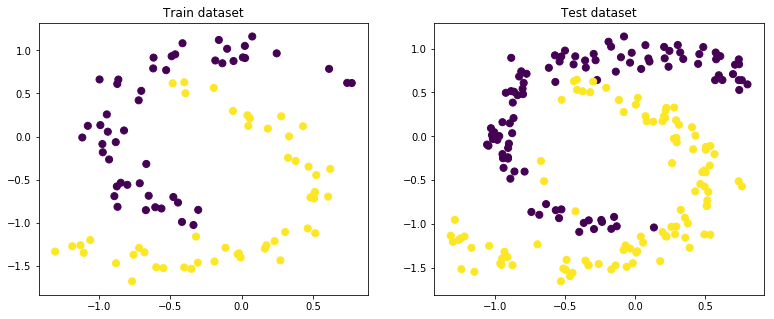

In [97]:
fig, axs = plt.subplots(1,  2, figsize=(13,5))
p = 0 # percentage to flip
Xtr, Ytr, Xts, Yts = two_moons(100, p)
axs[0].scatter(Xtr[:, 0], Xtr[:, 1], s=50, c=Ytr)
axs[0].set_title('Train dataset')
axs[1].scatter(Xts[:, 0], Xts[:, 1], s=50, c=Yts)
axs[1].set_title('Test dataset')

plt.show()

We now learn a function on the training set with Kernel Ridge Regression KRR.

#### KRR

KRR aims to learn the function

$$
    f(x) = \sum_{i=1}^n k(\hat x_i, x)c_i
$$ 

where the weights $c = [c_1, \dots, c_n]$ are learned by solving the following linear system

$$
(K + \lambda n I) c = Y
$$

where $\lambda$ is the regularization parameter that trades off between the data fitting term and the regularization term.

Learn with KRR on the training set Xtr Ytr and plot on the same set the learned function.

Complete KRR algorithm in the file regularizedKernLSTrain.py

In [98]:
def plot_tm_class(kernel, sigma, lam):
    fig, axs = plt.subplots(1,  1, figsize=(6,5))

    weights = KRR_Train(Xtr, Ytr, kernel, sigma=sigma, lam=lam)
    separatingFKernRLS(weights, Xtr, Ytr, kernel, sigma=sigma, Xte=Xtr, Yte=Ytr, axs=axs)
    axs.set_title('Prediction with ' + kernel + ' kernel, sigma = ' + str(sigma) + ', lambda = ' + str(lam))

    plt.show()
    
interactive_plot = interactive(plot_tm_class, {'manual': True},
                               kernel=['linear', 'gaussian'], 
                               sigma=(.1, 2.0), 
                               lam=(1e-5,1,1e-4))
output = interactive_plot.children[-1]

interactive_plot

interactive(children=(Dropdown(description='kernel', options=('linear', 'gaussian'), value='linear'), FloatSli…

How does the learned function change with respect to the type of kernel, $\lambda$ and $\sigma$?
What is the interplay between $\sigma$ and $\lambda$?

### Noisy two moons

We now load the same dataset again but we introduce some noise flipping some (15%) of the label between the two classes.

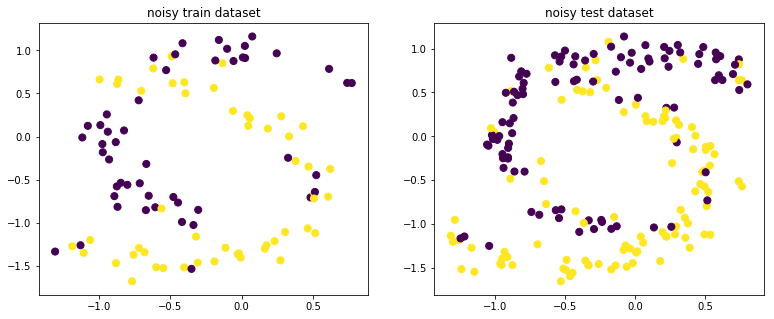

In [99]:
fig, axs = plt.subplots(1,  2, figsize=(13,5))
p = 15 # percentage to flip
Xtr, Ytr, Xts, Yts = two_moons(100, p)
axs[0].scatter(Xtr[:, 0], Xtr[:, 1], s=50, c=Ytr)
axs[0].set_title('noisy train dataset')
axs[1].scatter(Xts[:, 0], Xts[:, 1], s=50, c=Yts)
axs[1].set_title('noisy test dataset')

plt.show()

We plot the function learned on the training set Xtr, Ytr on both training set and test set Xts, Yts.

What happens now as $\sigma$ and $\lambda$ change? In particular focus on the test set.



In [100]:
def plot_tm_class(kernel, sigma, lam):
    fig, axs = plt.subplots(1,  2, figsize=(12,5))

    weights = KRR_Train(Xtr, Ytr, kernel, sigma=sigma, lam=lam)
    separatingFKernRLS(weights, Xtr, Ytr, kernel, sigma=sigma, Xte=Xtr, Yte=Ytr, axs=axs[0])
    axs[0].set_title('kernel prediction on Training set')
    separatingFKernRLS(weights, Xtr, Ytr, kernel, sigma=sigma, Xte=Xts, Yte=Yts, axs=axs[1])
    axs[1].set_title('kernel prediction on Test set')

    plt.show()
    
interactive_plot = interactive(plot_tm_class, {'manual': True},
                               kernel=['linear', 'gaussian'], 
                               sigma=(.1, 2.0), 
                               lam=(1e-5,1,1e-4))
output = interactive_plot.children[-1]

interactive_plot

interactive(children=(Dropdown(description='kernel', options=('linear', 'gaussian'), value='linear'), FloatSli…

In the following, we compute the Training and Test classification error. Study how they change. What's the difference between training and test?

In [101]:
lam = 10
sigma = .5
kernel = 'rbf'
def trainKRR(kernel, sigma, lam): 
    if kernel == 'gaussian':
        kernel = 'rbf'
    KRR = KernelRidge(kernel=kernel, gamma=1./(2*sigma**2), alpha=lam)
    KRR.fit(Xtr,Ytr)
    Ypred_ts = KRR.predict(Xts)
    Ypred_tr = KRR.predict(Xtr)
    
    C_error_ts = np.mean(np.sign(Ypred_ts) != Yts)
    C_error_tr = np.mean(np.sign(Ypred_tr) != Ytr)
    print(f'KRR Training classification error = {C_error_tr * 100}%')
    print(f'KRR Test classification error = {C_error_ts * 100}%')

interactive_plot = interactive(trainKRR, {'manual': True},
                               kernel=['linear', 'gaussian'], 
                               sigma=(.1, 2.0), 
                               lam=(1e-5,1,1e-4))
output = interactive_plot.children[-1]

interactive_plot

interactive(children=(Dropdown(description='kernel', options=('linear', 'gaussian'), value='linear'), FloatSli…

A proper value for the hyperparameters $\lambda$ and $\sigma$ has to be found.

Cross-validation (CV) techniques can be used to find them.

Fixed a $\sigma$, we now see how the validation error changes with respect to $\lambda$

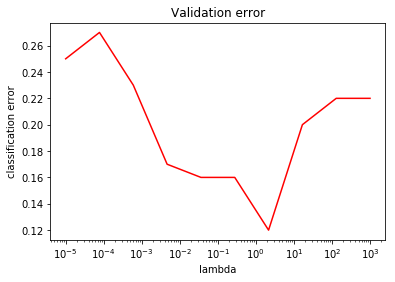

In [102]:
kernel='rbf'
sigma = .5
lambdas = np.logspace(-5,3,10)

KRR = KernelRidge(kernel=kernel, gamma=1./(2*sigma**2), alpha=lam)

hparam = [{'alpha': lambdas}]

c_acc_func = lambda estimator, X_test, Y_test: 1 - np.mean(np.sign(estimator.predict(X_test)) != np.sign(Y_test))
score = make_scorer(c_acc_func, greater_is_better=True)
clf = GridSearchCV(KRR, hparam, cv=5, scoring=c_acc_func)
clf.fit(Xtr, Ytr)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
y_true, y_pred = Yts, clf.predict(Xts)

means_c_err = 1-means
plt.semilogx(np.array(lambdas), np.array(means_c_err), 'r')
plt.title('Validation error')
plt.xlabel('lambda')
plt.ylabel('classification error')
plt.show()

Fixed a $\lambda$, we now see how the validation error changes with respect to $\sigma$.


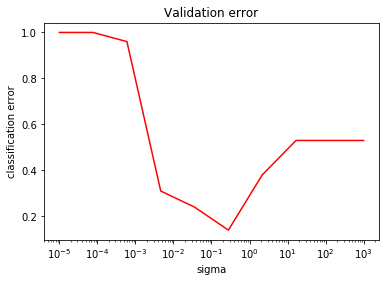

In [103]:
lam = .1
sigmas = np.logspace(-5,3,10)
hparam = [{'gamma': 1./(2*sigmas**2)}]

c_acc_func = lambda estimator, X_test, Y_test: 1 - np.mean(np.sign(estimator.predict(X_test)) != np.sign(Y_test))
score = make_scorer(c_acc_func, greater_is_better=True)
clf = GridSearchCV(KRR, hparam, cv=5, scoring=c_acc_func)
clf.fit(Xtr, Ytr)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

y_true, y_pred = Yts, clf.predict(Xts)
print()
means_c_err = 1-means
plt.semilogx(np.array(sigmas), np.array(means_c_err), 'r')
plt.title('Validation error')
plt.xlabel('sigma')
plt.ylabel('classification error')
plt.show()

We have seen that both $\lambda$ and $\sigma$ can cause overfitting. We then look for the best combination of them. 

In [104]:
lambdas = np.logspace(-5,3,10)
sigmas = np.logspace(-5,3,10)
hparam = [{'gamma': 1./(2*sigmas**2), 'alpha': lambdas}]

c_acc_func = lambda estimator, X_test, Y_test: 1 - np.mean(np.sign(estimator.predict(X_test)) != np.sign(Y_test))
score = make_scorer(c_acc_func, greater_is_better=True)
clf = GridSearchCV(KRR, hparam, cv=5, scoring=c_acc_func)
clf.fit(Xtr, Ytr)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

means = means.reshape((10,10))

Ypred = clf.best_estimator_.predict(Xts)

C_error = np.mean(np.sign(Ypred) != Yts)
print(f'KRR Test classification error with hyperparameters lambda and sigma tuned = {C_error * 100}%')
print(f'Best lambda = {clf.best_params_["alpha"]}')
print(f'Best sigma = {np.sqrt(1./(2*clf.best_params_["gamma"]))}')

KRR Test classification error with hyperparameters lambda and sigma tuned = 25.0%
Best lambda = 1e-05
Best sigma = 2.154434690031882


# Clustering

We now consider the unsupervised learning problem of clustering.

The dataset we focus on consists of two classes of 2D points.
The points of each class are distributed on a circle. The two circles have the same center but different radius.

We generate 400 points in the following way.

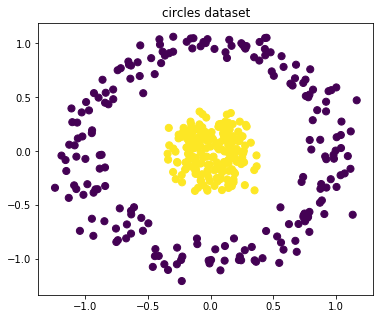

In [105]:
X, Y = make_circles(n_samples=400,noise=.1, factor=.2)
fig, axs = plt.subplots(1,  1, figsize=(6,5))


axs.scatter(X[:, 0], X[:, 1], s=50, c=Y)
axs.set_title('circles dataset')

plt.show()

Remember that in an unsupervised learning problem the labels are unknown as well as the number of classes.
But because studying how to find the proper number of clusters is out of the scope of this tutorial we just focus on k-means for k = 2 

We now compare the standard (linear) k-means algorithm with kernel k-means.
What is the difference between the two?
How does sigma affect the solution of kernel k-means?

In [107]:
k=2
def plot_tm_clust(sigma, kernel):
    KerKM = KernelKMeans(n_clusters= k, kernel=kernel, gamma=1./(2*sigma**2))
    out = KerKM.fit_predict(X)
    fig, axs = plt.subplots(1,  2, figsize=(13,5))
    axs[0].scatter(X[:, 0], X[:, 1], s=50, c='gray')
    axs[0].set_title('circles dataset')
    axs[1].scatter(X[:, 0], X[:, 1], s=50, c=out)
    axs[1].set_title(kernel +' k-means reconstruction')
    plt.show()
    
interactive_plot = interactive(plot_tm_clust, {'manual': True},
                               kernel=['linear', 'rbf'], 
                               sigma=(.01, 1,.05))
output = interactive_plot.children[-1]

interactive_plot

interactive(children=(FloatSlider(value=0.46, description='sigma', max=1.0, min=0.01, step=0.05), Dropdown(des…

# Large-Scale learning

Given a training set $X,Y$ of $n$ points, KRR in its basic form computes the weights $c$ as following

$$
c = (K + \lambda n I)^{-1} Y,
$$

with $K$ being the $n\times n$ kernel matrix. Computing the inverse of the $n\times n$ matrix, which has a time complexity of roughly $O(n^3)$,
is the computational bottleneck.
This method scales cubically in the number of points of the training set, making it impractical for large-scale scenarios where the training points are hundreds of thousands if not millions.

We now focus on the computational aspect of KRR and study how it scales with respect to the number of points.

We start loading a subset of the SUSY dataset (a high energy physics binary classification dataset of about 5 million points).
We also normalize the data according to the z-score (subtract the mean and divide by the standard deviation each of the features).

In [109]:
ttp = .8 # ratio of training/test set
def load_SUSY(subset_size):
    print(f'Selecting a subset of {subset_size} points over the SUSY dataset')
    X = spio.loadmat('./Susy_small.mat')['X_small'][:subset_size,:]
    Y = X[:,0].reshape(-1,1)
    Y = (Y-.5)*2
    X = X[:,1:]

    ntt = X.shape[0]
    ntr = int(ntt*ttp)
    Xtr = X[:ntr,:]
    Ytr = Y[:ntr]
    Xts = X[ntr:,:]
    Yts = Y[ntr:]
    print(f'Training set size ntr = {ntr}')
    print(f'Test set size nts = {ntt-ntr}')
    print('---')
    print(f'Normalizing points according to z-score')
    scaler = StandardScaler()
    scaler.fit(Xtr)
    Xtr = scaler.transform(Xtr)
    Xts = scaler.transform(Xts)
    return Xtr, Ytr, Xts, Yts

interactive_plot = interactive(load_SUSY, {'manual': True},
                                subset_size=[5000, 10000, 20000, 50000, 200000])
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(Dropdown(description='subset_size', options=(5000, 10000, 20000, 50000, 200000), value=5…

For the following experiments, we fix a $\sigma$ and a $\lambda$ because we do not focus particularly on the accuracy of the function we learn.
CV procedures can always be applied to improve the accuracy but at the cost of more computational time.

First test the classical KRR implementation of scikit-learn library on a small subset of 5000 points.

In [112]:
Xtr, Ytr, Xts, Yts = interactive_plot.result
# For ntr too big IT MAY NOT TERMINATE
lam = 1e-1
sigma = 4
kernel = 'rbf'

tic()
KRR = KernelRidge(kernel=kernel, gamma=1./(2*sigma**2), alpha=lam)
KRR.fit(Xtr,Ytr)
time_KRR = toc()
Ypred = KRR.predict(Xts)
aa = KRR.predict(Xtr)

cc = np.mean(np.sign(aa) != np.sign(Ytr))
C_error = np.mean(np.sign(Ypred) != np.sign(Yts))

print(f'KRR Classification error = {C_error * 100:.2f}%')
print(f'KRR computational time = {time_KRR:.2f} sec')

KRR Classification error = 20.70%
KRR computational time = 0.64 sec


Now go back and slowly increase the subset of points of the dataset.
How does the runtime change?
Be careful because for values too big it may require more time than what you have for this tutorial ;)

### FALKON

We now compare the KRR performance with an approximated method named FALKON.

FALKON exploits 3 main ingredients which are random projections, preconditioning, and iterative solvers (in our case conjugate gradient).

FALKON learns functions of the form

$$
f(x) = \sum_{i = 1}^{\color{red}M} k(\tilde x_i, x) \tilde c_i
$$

where $\{\tilde x_1,\dots \tilde x_M\}$ is a subset of $M < n$ points sampled uniformly at random from the n of the training set $\{\hat x_1,\dots \hat x_n\}$.

The weights $\tilde c = [\tilde c_1,\dots, \tilde c_M]$ are learned by solving the linear system 

$$
(K_{nM}^\top K_{nM} +\lambda n K_{MM}) \tilde c = K_{nM}^\top Y
$$

where $K_{nM}$ is the $n \times M$ matrix defined by  $(K)_{i,j} = k(\hat x_i,\tilde x_j)$. This can be seen as sampling uniformly at random $M$ columns from the original $n \times n$ kernel matrix $K$. 

The above linear system is solved iteratively with the Conjugate Gradient method, but only after being preconditioned.

Preconditioning the linear system allows obtaining another linear system with the same solution but with a better condition number which allows the new linear system to be solved with less iteration with respect to the original one.

In details, FALKON exploits the preconditioner

$$
PP^\top = (\frac{n}{M}K_{MM}^2 + \lambda n K_{MM})^{-1}
$$

and solves iteratively with Conjugate Gradient the preconditioned linear system

$$
P^\top(K_{nM}^\top K_{nM} +\lambda n K_{MM})P \beta = P^\top K_{nM}^\top Y \qquad \text{ with } \tilde c = P \beta
$$

The time complexity of FALKON is $O(nMt)$ where $t$ is the number of iterations of Conjugate Gradient.
It can be proved that to get a statistically accurate solution, M can be picked to be $O(\sqrt n)$ and only $t = O(\log(n))$ iterations are needed to converge. This gives to FALKON an overall time complexity of $O(n\sqrt n \log(n))$

More details of this algorithm can be found in the paper https://arxiv.org/abs/1705.10958, and an efficient implementation for GPU in MATLAB can be found https://github.com/LCSL/FALKON_paper (python Multi-GPU implementation coming soon).

For the next experiment, we fix all the free parameters of FALKON ($\sigma, \lambda, t, M$).

Repeat the same pipeline done for KRR with FALKON now, and see how long it takes to run as the number of training points grows.

In [113]:
Xtr, Ytr, Xts, Yts = interactive_plot.result
sigma = 4
kernel = lambda A,B: rbf_kernel(A,B, gamma=1./(2*sigma**2))
lam = 1e-6
T = 20
M = 500

tic()
alpha, C = FALKON(Xtr, Ytr, M, kernel, lam, T, verbose=True)
time_falkon = toc()
Ypred = kernel(Xts, C).dot(alpha)
c_err_func = lambda Ypred, Ytrue: np.mean(np.sign(Ypred) != np.sign(Ytrue))
print(f'FALKON Classification error = {c_err_func(Ypred, Yts) * 100:.2f}%')
print(f'FALKON computational time = {time_falkon:.2f} sec')

Computing preconditioner
Starting CG iterations
Iteration 1 out of 20
Iteration 2 out of 20
Iteration 3 out of 20
Iteration 4 out of 20
Iteration 5 out of 20
Iteration 6 out of 20
Iteration 7 out of 20
Iteration 8 out of 20
Iteration 9 out of 20
Iteration 10 out of 20
Iteration 11 out of 20
Iteration 12 out of 20
Iteration 13 out of 20
Iteration 14 out of 20
Iteration 15 out of 20
Iteration 16 out of 20
Iteration 17 out of 20
Iteration 18 out of 20
Iteration 19 out of 20
Iteration 20 out of 20
FALKON Classification error = 20.10%
FALKON computational time = 0.47 sec


We can see that FALKON achieves the same accuracy of KRR but in a fraction of the time.

## The effect of random projections on regularization

We now focus on the level of approximation induced by the parameter $M$. We then fix $\sigma, \lambda, t$

Take a subset of SUSY of 5000 points.

How does the accuracy changes both in validation and training with respect to $M$?

In [114]:
Xtr, Ytr, Xts, Yts = interactive_plot.result
kerpar_list = [2]
lam_list = [1e-5]
m_list = [10, 50, 80, 100, 400, 800, 1000, 2000, 3000]
kernel = lambda sigma: lambda A,B: rbf_kernel(A,B, gamma=1./(2*sigma**2))
c_err_func = lambda Ypred, Ytrue: np.mean(np.sign(Ypred) != np.sign(Ytrue))

best_l, best_s, best_m, vm, vs, tm, ts = GridSearchCV_FALKON(Xtr, Ytr, kernel, lam_list, kerpar_list, m_list, c_err_func)

Processing parameters conf 1 out of 9
Processing parameters conf 2 out of 9
Processing parameters conf 3 out of 9
Processing parameters conf 4 out of 9
Processing parameters conf 5 out of 9
Processing parameters conf 6 out of 9
Processing parameters conf 7 out of 9
Processing parameters conf 8 out of 9
Processing parameters conf 9 out of 9
Done!


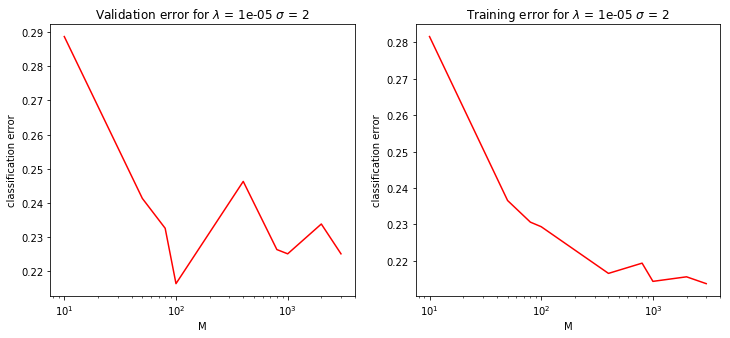

In [115]:
fig, axs = plt.subplots(1,  2, figsize=(12,5))
axs[0].semilogx(np.array(m_list), np.array(vm.reshape(len(kerpar_list)*len(lam_list)*len(m_list),1)), 'r')
axs[0].set_title(f'Validation error for $\lambda$ = {lam_list[0]} $\sigma$ = {kerpar_list[0]}')
axs[0].set_xlabel('M')
axs[0].set_ylabel(f'classification error')

axs[1].semilogx(np.array(m_list), np.array(tm.reshape(len(kerpar_list)*len(lam_list)*len(m_list),1)), 'r')
axs[1].set_title(f'Training error for $\lambda$ = {lam_list[0]} $\sigma$ = {kerpar_list[0]}')
axs[1].set_xlabel('M')
axs[1].set_ylabel(f'classification error')
# plt.gca().invert_xaxis()
plt.show()

Now fix $M$ and vary lambda. What do you observe? 

In [116]:
Xtr, Ytr, Xts, Yts = interactive_plot.result
kerpar_list = [2]
lam_list = np.logspace(-15,1,15)
m_list = [400]
kernel = lambda sigma: lambda A,B: rbf_kernel(A,B, gamma=1./(2*sigma**2))
c_err_func = lambda Ypred, Ytrue: np.mean(np.sign(Ypred) != np.sign(Ytrue))

best_l, best_s, best_m, vm, vs, tm, ts = GridSearchCV_FALKON(Xtr, Ytr, kernel, lam_list, kerpar_list, m_list, c_err_func)

Processing parameters conf 1 out of 15
Processing parameters conf 2 out of 15
Processing parameters conf 3 out of 15
Processing parameters conf 4 out of 15
Processing parameters conf 5 out of 15
Processing parameters conf 6 out of 15
Processing parameters conf 7 out of 15
Processing parameters conf 8 out of 15
Processing parameters conf 9 out of 15
Processing parameters conf 10 out of 15
Processing parameters conf 11 out of 15
Processing parameters conf 12 out of 15
Processing parameters conf 13 out of 15
Processing parameters conf 14 out of 15
Processing parameters conf 15 out of 15
Done!


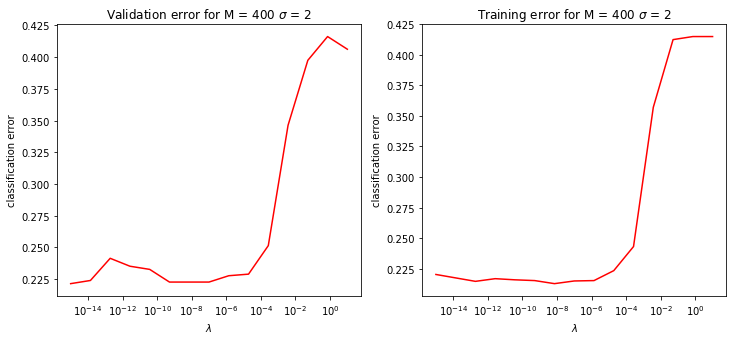

In [117]:
fig, axs = plt.subplots(1,  2, figsize=(12,5))

axs[0].semilogx(np.array(lam_list), np.array(vm.reshape(len(kerpar_list)*len(lam_list)*len(m_list),1)), 'r')
axs[0].set_title(f'Validation error for M = {m_list[0]} $\sigma$ = {kerpar_list[0]}')
axs[0].set_xlabel('$\lambda$')
axs[0].set_ylabel(f'classification error')
# plt.gca().invert_xaxis()

axs[1].semilogx(np.array(lam_list), np.array(tm.reshape(len(kerpar_list)*len(lam_list)*len(m_list),1)), 'r')
axs[1].set_title(f'Training error for M = {m_list[0]} $\sigma$ = {kerpar_list[0]}')
axs[1].set_xlabel('$\lambda$')
axs[1].set_ylabel(f'classification error')

plt.show()

Can you reach training error 0?